## Create RAG ratings for the aggregate data

## Set-up

### Packages and file paths

In [1]:
# Import required packages
from dataclasses import dataclass
import numpy as np
import os
import pandas as pd

In [2]:
# File paths
@dataclass(frozen=True)
class Paths:
    '''Paths to data and files'''
    survey = '../data/survey_data'
    aggregate = 'aggregate_scores.csv'


paths = Paths()

### Import aggregate scores

In [3]:
data = pd.read_csv(os.path.join(paths.survey, paths.aggregate))
data.head()

,school_lab,variable,mean,count,year_group_lab,gender_lab,fsm_lab,sen_lab
0,School A,birth_you_age_score,7.584112,107.0,All,All,All,All
1,School B,birth_you_age_score,7.657407,108.0,All,All,All,All
2,School C,birth_you_age_score,8.510417,96.0,All,All,All,All
3,School D,birth_you_age_score,7.815789,95.0,All,All,All,All
4,School E,birth_you_age_score,7.773810,84.0,All,All,All,All


In [4]:
test = data[
    (data['variable'] == 'autonomy_score') &
    (data['year_group_lab'] == 'All') &
    (data['gender_lab'] == 'All') &
    (data['fsm_lab'] == 'All') &
    (data['sen_lab'] == 'All')]
test

,school_lab,variable,mean,count,year_group_lab,gender_lab,fsm_lab,sen_lab
7,School A,autonomy_score,17.930556,72.0,All,All,All,All
8,School B,autonomy_score,17.680000,75.0,All,All,All,All
9,School C,autonomy_score,17.764706,68.0,All,All,All,All
10,School D,autonomy_score,18.157895,57.0,All,All,All,All
11,School E,autonomy_score,18.500000,54.0,All,All,All,All
12,School F,autonomy_score,17.290323,62.0,All,All,All,All
13,School G,autonomy_score,18.722222,54.0,All,All,All,All


In [5]:
test['mean'].sort_values()

12    17.290323
8     17.680000
9     17.764706
7     17.930556
10    18.157895
11    18.500000
13    18.722222
Name: mean, dtype: float64

We find weighted average rather than mean in original raw data, as that is the approach we will use for the benchmarking data (where can't access raw data), so best to be consistent.

#### Method 1

In [6]:
from statsmodels.stats.weightstats import DescrStatsW

In [7]:
%%time
weighted = DescrStatsW(test['mean'], weights=test['count'], ddof=0)

CPU times: user 252 µs, sys: 21 µs, total: 273 µs
Wall time: 278 µs


In [8]:
print(weighted.mean)
print(weighted.std)

17.968325791855204
0.4402334195243224


#### Method 2

Below is from https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy

It returns the biased variance. For small samples, might want to use unbiased. This answer though is like weighted version of np.std().

In [9]:
import math


def weighted_avg_and_std(values, weights):
    '''
    Return the weighted average and standard deviation.
    This calculation normalised the weights (so sum=1, and so can't all be 0)

    values, weights -- NumPy ndarrays with the same shape.
    '''
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

In [10]:
%%time
test_mean, test_sd = weighted_avg_and_std(test['mean'], test['count'])

CPU times: user 932 µs, sys: 79 µs, total: 1.01 ms
Wall time: 1.02 ms


In [11]:
test_mean, test_sd

(17.968325791855204, 0.4402334195243224)

#### Apply mean and SD to find RAG

In [12]:
# Find 1 SD above and below the mean
lower_boundary = test_mean - test_sd
upper_boundary = test_mean + test_sd

# Populate rag depending on whether more than 1SD from the mean
conditions = [(test['mean'] <= lower_boundary),
              (test['mean'] > lower_boundary) & (test['mean'] < upper_boundary),
              (test['mean'] >= upper_boundary)]
choices = ['below', 'average', 'above']
test.loc[:, 'rag'] = np.select(conditions, choices, default=np.nan)
test

/tmp/ipykernel_31959/3634103158.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'rag'] = np.select(conditions, choices, default=np.nan)


,school_lab,variable,mean,count,year_group_lab,gender_lab,fsm_lab,sen_lab,rag
7,School A,autonomy_score,17.930556,72.0,All,All,All,All,average
8,School B,autonomy_score,17.680000,75.0,All,All,All,All,average
9,School C,autonomy_score,17.764706,68.0,All,All,All,All,average
10,School D,autonomy_score,18.157895,57.0,All,All,All,All,average
11,School E,autonomy_score,18.500000,54.0,All,All,All,All,above
12,School F,autonomy_score,17.290323,62.0,All,All,All,All,below
13,School G,autonomy_score,18.722222,54.0,All,All,All,All,above


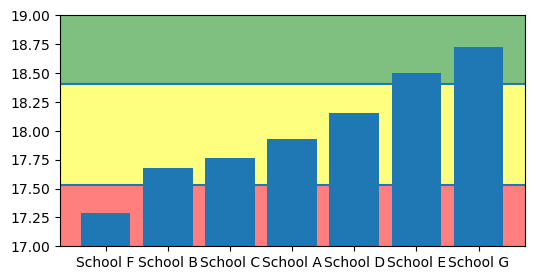

In [13]:
import matplotlib.pyplot as plt

# Sort by mean value
test_order = test.sort_values(by='mean')

# Find y axis limits
ymin = math.floor(test_order['mean'].min())
ymax = math.ceil(test_order['mean'].max())

fig, ax = plt.subplots(figsize=(6,3))

ax.bar(test_order['school_lab'], test_order['mean'], zorder=2)
plt.ylim(ymin, ymax)

plt.axhline(y=lower_boundary)
plt.axhline(y=upper_boundary)

ax.axhspan(ymin, lower_boundary, facecolor='red', alpha=0.5)
ax.axhspan(lower_boundary, upper_boundary, facecolor='yellow', alpha=0.5)
ax.axhspan(upper_boundary, ymax, facecolor='green', alpha=0.5)